# ✅ 使用 SAHI 将文件夹中的RAW图片全部切片并保存

## RAW数据集
"/mnt/D/01_Projects/01_swd/02_code/sahi/rest_2024_images"： 
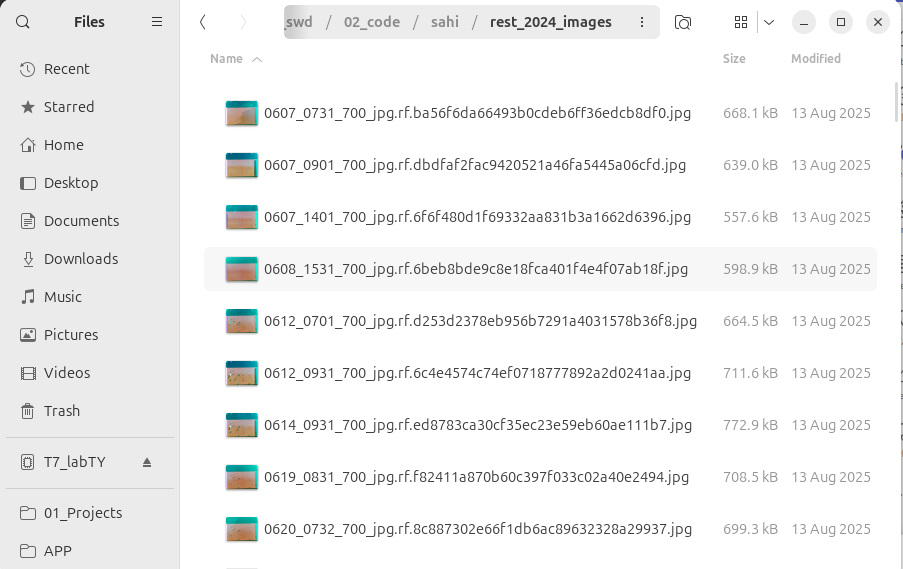

## 然后用X-AnyLabeling标记切好的图片。
这里是用的X-AnyLabeling的AI标图帮助标记的

"/mnt/D/01_Projects/01_swd/02_code/sahi/rest_2024_images_sliced"：
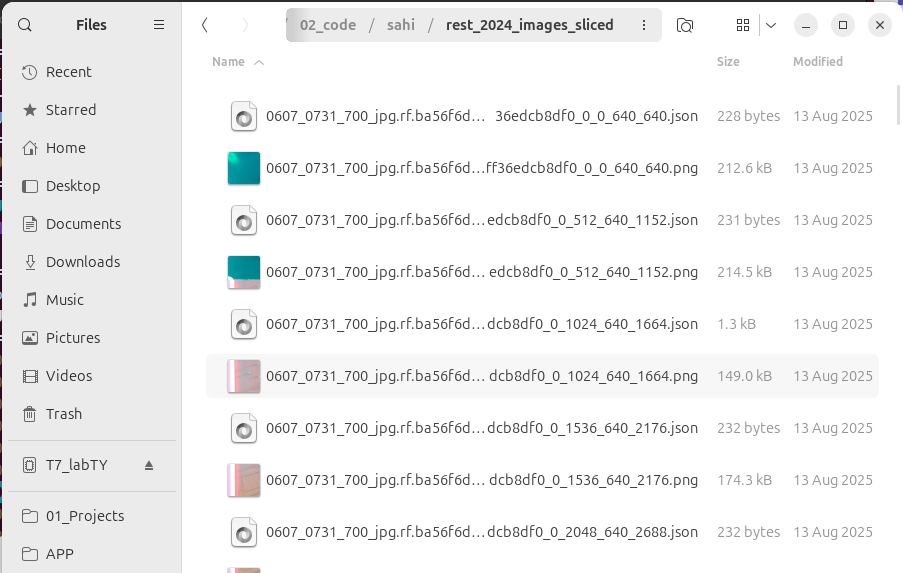

这里代码只是切图。完成后需要用X-AnyLabeling来标记得到.json的annotation文件

In [1]:
# # 这里代码只是切图。完成后需要用X-AnyLabeling来标记得到.json的annotation文件   ***弃用，改用下面的脚本***
# import os
# from sahi.slicing import slice_image

# # 设置参数
# input_folder = "/workspace/models/SAHI/demo_data/"       # 替换为你的图片文件夹路径
# output_folder = "/workspace/models/SAHI/demo_data_sliced"
# slice_height = 640
# slice_width = 640
# overlap_ratio = 0.2  # 高宽方向统一使用 0.2

# os.makedirs(output_folder, exist_ok=True)

# # 遍历图片文件
# for filename in os.listdir(input_folder):
#     if filename.lower().endswith((".jpg", ".jpeg", ".png")):
#         image_path = os.path.join(input_folder, filename)
#         name_no_ext = os.path.splitext(filename)[0]

#         print(f"📎 正在切片: {filename}")

#         # 自动切片 + 导出图像
#         slice_image(
#             image=image_path,
#             output_file_name=name_no_ext,
#             output_dir=output_folder,
#             slice_height=slice_height,
#             slice_width=slice_width,
#             overlap_height_ratio=overlap_ratio,
#             overlap_width_ratio=overlap_ratio,
#             auto_slice_resolution=False,
#             verbose=True,
#         )

# 正式运行
## 核心代码

In [ ]:
import os
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
import numpy as np
import cv2
from rich.progress import track
from rich import print

IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")

# ---------- 核心：单张图切片（OpenCV） ----------
def slice_image_cv2(
    image_path: Path,
    output_dir: Path,
    tile_h: int = 640,
    tile_w: int = 640,
    overlap: float = 0.2,
    out_ext: str = ".jpg",           # 用 JPG 比 PNG 快很多
    jpeg_quality: int = 85,
    png_compression: int = 3,        # 0(最快,大)~9(最慢,小)
    keep_small_edge: bool = True,    # 末端不足一片时仍保存小片
) -> int:
    """
    只切图：返回保存的切片数。命名为  name_x0_y0_x1_y1.ext（与 SAHI 基本兼容）
    """
    # 读图：np.fromfile+imdecode 更稳更快
    buf = np.fromfile(str(image_path), dtype=np.uint8)
    if buf.size == 0:
        return 0
    img = cv2.imdecode(buf, cv2.IMREAD_COLOR)
    if img is None:
        return 0
    H, W = img.shape[:2]

    # 步长（带重叠）
    overlap = max(0.0, min(0.99, overlap))
    sh = max(1, int(round(tile_h * (1.0 - overlap))))
    sw = max(1, int(round(tile_w * (1.0 - overlap))))

    # 生成起点，确保右/下边缘覆盖
    ys = list(range(0, max(1, H - tile_h + 1), sh))
    xs = list(range(0, max(1, W - tile_w + 1), sw))
    if keep_small_edge:
        if ys[-1] != max(0, H - tile_h): ys.append(max(0, H - tile_h))
        if xs[-1] != max(0, W - tile_w): xs.append(max(0, W - tile_w))

    stem = image_path.stem
    out_ext = out_ext.lower()
    os.makedirs(output_dir, exist_ok=True)

    # 写图参数
    if out_ext in (".jpg", ".jpeg"):
        imwrite_params = [cv2.IMWRITE_JPEG_QUALITY, int(jpeg_quality)]
    elif out_ext == ".png":
        imwrite_params = [cv2.IMWRITE_PNG_COMPRESSION, int(png_compression)]
    else:
        imwrite_params = []  # 其他格式走默认

    saved = 0
    for y0 in ys:
        y1 = min(y0 + tile_h, H)
        for x0 in xs:
            x1 = min(x0 + tile_w, W)
            crop = img[y0:y1, x0:x1]
            # 与 SAHI 类似的命名：x0_y0_x1_y1
            out_name = f"{stem}_{x0}_{y0}_{x1}_{y1}{out_ext}"
            out_path = output_dir / out_name
            try:
                cv2.imwrite(str(out_path), crop, imwrite_params)
                saved += 1
            except Exception:
                pass
    return saved

# ---------- 批量：文件夹切片（并行按“图”） ----------
def slice_folder_cv2(
    input_folder: Path,
    output_folder: Path = None,
    tile_h: int = 640,
    tile_w: int = 640,
    overlap: float = 0.2,
    out_ext: str = ".jpg",
    jpeg_quality: int = 85,
    png_compression: int = 3,
    recurse: bool = False,
    max_workers: int | None = None
    ) -> dict:
    """
    批量切图；返回 {'images':N, 'tiles':M, 'failed':K}
    """
    if output_folder is None:
        output_folder = input_folder.parent / f"{input_folder.name}_sliced"
    output_folder.mkdir(parents=True, exist_ok=True)

    it = input_folder.rglob("*") if recurse else input_folder.iterdir()
    images = [p for p in it if p.is_file() and p.suffix.lower() in IMG_EXTS]
    if not images:
        print(f"[slice] no images in {input_folder}")
        return {"images": 0, "tiles": 0, "failed": 0}

    if max_workers is None:
        cpu = os.cpu_count() or 8
        max_workers = max(2, min(16, cpu * 4))  # 留出余量，封顶16
        

    def _one(p: Path):
        try:
            return p, slice_image_cv2(
                p, output_folder,
                tile_h=tile_h, tile_w=tile_w, overlap=overlap,
                out_ext=out_ext, jpeg_quality=jpeg_quality, png_compression=png_compression
            )
        except Exception:
            return p, 0

    tiles = failed = 0

    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futures = [ex.submit(_one, p) for p in images]
        for fut in as_completed(futures):
            _, saved = fut.result()
            tiles += saved
            if saved == 0:
                failed += 1

    print(f"[slice] images={len(images)} tiles={tiles} failed={failed} -> {output_folder}")
    return {"images": len(images), "tiles": tiles, "failed": failed}

def delete_corrupt_images_fast(
    root_dir,
    recurse=False,
    exts=(".jpg", ".jpeg", ".png"),  # 你的数据主要是 JPG，就保持精简更快
    min_bytes=32,                    # 小于这个大小直接判坏图
    max_workers=None,                # 默认=CPU*4
    dry_run=False,                   # 仅统计不删除
):
    root = Path(root_dir)
    if recurse:
        files = [p for p in root.rglob("*") if p.is_file() and p.suffix.lower() in exts]
    else:
        files = [p for p in root.iterdir() if p.is_file() and p.suffix.lower() in exts]

    if max_workers is None:
        cpu = os.cpu_count() or 8
        max_workers = max(2, min(16, cpu * 4))  # 留出余量，封顶16

    def is_bad(p: Path):
        # 1) 空/超小文件：直接坏
        try:
            if p.stat().st_size < min_bytes:
                return p, True, "too_small"
        except Exception:
            return p, True, "stat_error"

        # 2) OpenCV 高速解码校验
        try:
            data = np.fromfile(str(p), dtype=np.uint8)     # 比 open().read() 更快更稳
            if data.size == 0:
                return p, True, "empty"
            img = cv2.imdecode(data, cv2.IMREAD_UNCHANGED) # 成功则返回 ndarray
            if img is None:
                return p, True, "imdecode_none"
            h, w = img.shape[:2]
            if h == 0 or w == 0:
                return p, True, "zero_dim"
            return p, False, ""
        except Exception as e:
            return p, True, f"decode_error:{type(e).__name__}"

    scanned = 0
    deleted = 0

    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        for fut in as_completed([ex.submit(is_bad, p) for p in files]):
            p, bad, _reason = fut.result()
            scanned += 1
            if bad:
                if not dry_run:
                    try:
                        p.unlink(missing_ok=True)
                    except Exception:
                        pass
                deleted += 1

    kept = scanned - deleted
    print(f"[clean-fast] scanned={scanned} kept={kept} deleted={deleted}")
    return {"scanned": scanned, "kept": kept, "deleted": deleted}

## 查看根目录下需要运行的文件夹

In [3]:
from pathlib import Path

if __name__ == "__main__":
    # === 1) 给定一个根目录 ===
    root_dir = Path("/workspace/models/SAHI/run_v7")
    # end_with = "_sliced"
    end_with = "_data"

    # === 2) 遍历所有子目录 ===
    sub_dirs = list(root_dir.glob("**/*" + end_with))


    if not sub_dirs:
        print(f"没有找到 *{end_with} 目录")
        exit(0)

    print(f"找到以下 {end_with} 数据集：")
    for i, d in enumerate(sub_dirs):
        print(f"[{i}] {d}")

    # === 3) 让你选择要跑的目录 ===
    idx_str = input("请输入要处理的编号 (多个用逗号分隔, 回车默认全选): ").strip()
    if idx_str:
        indices = [int(x) for x in idx_str.split(",")]
        chosen_dirs = [sub_dirs[i] for i in indices]
    else:
        chosen_dirs = sub_dirs
    
    print(f"将处理以下 {end_with} 目录：")
    for i, d in enumerate(chosen_dirs):
        print(f"- {i+1}. {d}")

找到以下 _data 数据集：

[0] /workspace/models/SAHI/run_v7/ms1_0726-0809_11/raw_data

[1] /workspace/models/SAHI/run_v7/air1_0729-0813_5/raw_data

[2] /workspace/models/SAHI/run_v7/air1_0826-0909_21_no/raw_data

[3] /workspace/models/SAHI/run_v7/air1_0909-0923_02_wait/raw_data

[4] /workspace/models/SAHI/run_v7/air1_0923-1007_01_wait/raw_data

[5] /workspace/models/SAHI/run_v7/air2_0729-0813_04/raw_data

[6] /workspace/models/SAHI/run_v7/air2_0826-0909_25_no/raw_data

[7] /workspace/models/SAHI/run_v7/air2_0923-1007_02_wait/raw_data

[8] /workspace/models/SAHI/run_v7/jeff_0613-0624_04_ok/raw_data

[9] /workspace/models/SAHI/run_v7/jeff_0624-0702_01_ok/raw_data

[10] /workspace/models/SAHI/run_v7/jeff_0730-0813_01/raw_data

[11] /workspace/models/SAHI/run_v7/lloyd_0603-0618_31/raw_data

[12] /workspace/models/SAHI/run_v7/lloyd_0715-0729_04/raw_data

[13] /workspace/models/SAHI/run_v7/lloyd_0826-0909_04/raw_data

[14] /workspace/models/SAHI/run_v7/ms1_0605-0621_40/raw_data

[15] /workspace/models/SAHI/run_v7/ms1_0621-0710_04/raw_data

[16] /workspace/models/SAHI/run_v7/ms1_0710-0726_36/raw_data

[17] /workspace/models/SAHI/run_v7/ms1_0809-0823_34/raw_data

[18] /workspace/models/SAHI/run_v7/ms1_0823-0906_25_no/raw_data

[19] /workspace/models/SAHI/run_v7/ms1_0906-0920_10_no/raw_data

[20] /workspace/models/SAHI/run_v7/ms1_0920-1004_04_wait/raw_data

[21] /workspace/models/SAHI/run_v7/ms1_1004-1020_21_wait/raw_data

[22] /workspace/models/SAHI/run_v7/ms2_0601-0605_01_wait/raw_data

[23] /workspace/models/SAHI/run_v7/ms2_0621-0710_01/raw_data

[24] /workspace/models/SAHI/run_v7/ms2_0726-0809_13/raw_data

[25] /workspace/models/SAHI/run_v7/ms2_0809-0823_10/raw_data

[26] /workspace/models/SAHI/run_v7/ms2_1004-1020_02_wait/raw_data

[27] /workspace/models/SAHI/run_v7/southfarm1_0701-0715_04/raw_data

[28] /workspace/models/SAHI/run_v7/southfarm1_0715-0813_01_wait/raw_data

[29] /workspace/models/SAHI/run_v7/southfarm1_0924-1007_01_no/raw_data

[30] /workspace/models/SAHI/run_v7/southfarm2_1007-1022_61_wait/raw_data

[31] /workspace/models/SAHI/run_v7/sw1_0605-0613_07_ok/raw_data

[32] /workspace/models/SAHI/run_v7/sw1_0627-0711_02/raw_data

[33] /workspace/models/SAHI/run_v7/sw1_0711-0725_03/raw_data

[34] /workspace/models/SAHI/run_v7/sw1_0808-0823_01/raw_data

[35] /workspace/models/SAHI/run_v7/sw1_0927-1011_01_wait/raw_data

[36] /workspace/models/SAHI/run_v7/sw2_0725-0808_02/raw_data

[37] /workspace/models/SAHI/run_v7/sw2_0808-0823_04/raw_data

将处理以下 _data 目录：

- 1. /workspace/models/SAHI/run_v7/ms1_0726-0809_11/raw_data

- 2. /workspace/models/SAHI/run_v7/air1_0729-0813_5/raw_data

- 3. /workspace/models/SAHI/run_v7/air1_0826-0909_21_no/raw_data

- 4. /workspace/models/SAHI/run_v7/air1_0909-0923_02_wait/raw_data

- 5. /workspace/models/SAHI/run_v7/air1_0923-1007_01_wait/raw_data

- 6. /workspace/models/SAHI/run_v7/air2_0729-0813_04/raw_data

- 7. /workspace/models/SAHI/run_v7/air2_0826-0909_25_no/raw_data

- 8. /workspace/models/SAHI/run_v7/air2_0923-1007_02_wait/raw_data

- 9. /workspace/models/SAHI/run_v7/jeff_0613-0624_04_ok/raw_data

- 10. /workspace/models/SAHI/run_v7/jeff_0624-0702_01_ok/raw_data

- 11. /workspace/models/SAHI/run_v7/jeff_0730-0813_01/raw_data

- 12. /workspace/models/SAHI/run_v7/lloyd_0603-0618_31/raw_data

- 13. /workspace/models/SAHI/run_v7/lloyd_0715-0729_04/raw_data

- 14. /workspace/models/SAHI/run_v7/lloyd_0826-0909_04/raw_data

- 15. /workspace/models/SAHI/run_v7/ms1_0605-0621_40/raw_data

- 16. /workspace/models/SAHI/run_v7/ms1_0621-0710_04/raw_data

- 17. /workspace/models/SAHI/run_v7/ms1_0710-0726_36/raw_data

- 18. /workspace/models/SAHI/run_v7/ms1_0809-0823_34/raw_data

- 19. /workspace/models/SAHI/run_v7/ms1_0823-0906_25_no/raw_data

- 20. /workspace/models/SAHI/run_v7/ms1_0906-0920_10_no/raw_data

- 21. /workspace/models/SAHI/run_v7/ms1_0920-1004_04_wait/raw_data

- 22. /workspace/models/SAHI/run_v7/ms1_1004-1020_21_wait/raw_data

- 23. /workspace/models/SAHI/run_v7/ms2_0601-0605_01_wait/raw_data

- 24. /workspace/models/SAHI/run_v7/ms2_0621-0710_01/raw_data

- 25. /workspace/models/SAHI/run_v7/ms2_0726-0809_13/raw_data

- 26. /workspace/models/SAHI/run_v7/ms2_0809-0823_10/raw_data

- 27. /workspace/models/SAHI/run_v7/ms2_1004-1020_02_wait/raw_data

- 28. /workspace/models/SAHI/run_v7/southfarm1_0701-0715_04/raw_data

- 29. /workspace/models/SAHI/run_v7/southfarm1_0715-0813_01_wait/raw_data

- 30. /workspace/models/SAHI/run_v7/southfarm1_0924-1007_01_no/raw_data

- 31. /workspace/models/SAHI/run_v7/southfarm2_1007-1022_61_wait/raw_data

- 32. /workspace/models/SAHI/run_v7/sw1_0605-0613_07_ok/raw_data

- 33. /workspace/models/SAHI/run_v7/sw1_0627-0711_02/raw_data

- 34. /workspace/models/SAHI/run_v7/sw1_0711-0725_03/raw_data

- 35. /workspace/models/SAHI/run_v7/sw1_0808-0823_01/raw_data

- 36. /workspace/models/SAHI/run_v7/sw1_0927-1011_01_wait/raw_data

- 37. /workspace/models/SAHI/run_v7/sw2_0725-0808_02/raw_data

- 38. /workspace/models/SAHI/run_v7/sw2_0808-0823_04/raw_data

## 开始执行核心代码，切图

In [4]:
# === 4) 逐个目录执行：删坏图 + 切片 ===    
slice_height, slice_width, overlap_ratio = 640, 640, 0.2
for folder in track(chosen_dirs, description="Processing folders"):
    delete_corrupt_images_fast(folder)
    print(f"--- 切片 {folder} ---")
    slice_folder_cv2(
        input_folder=folder,
        output_folder=None,  # None 则自动在同级创建 xxx_sliced
        tile_h=640, tile_w=640, overlap=0.2,
        out_ext=".jpg", jpeg_quality=85,
        recurse=False,           # 若有多级子目录，改 True
        max_workers=None,        # 默认 16
    )

Output()

scanned=1386 kept=1386 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/ms1_0726-0809_11/raw_data ---

images=1386 tiles=87318 failed=0 -> /workspace/models/SAHI/run_v7/ms1_0726-0809_11/raw_data_sliced

scanned=149 kept=149 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/air1_0729-0813_5/raw_data ---

images=149 tiles=9387 failed=0 -> /workspace/models/SAHI/run_v7/air1_0729-0813_5/raw_data_sliced

scanned=2991 kept=2991 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/air1_0826-0909_21_no/raw_data ---

images=2991 tiles=26919 failed=0 -> /workspace/models/SAHI/run_v7/air1_0826-0909_21_no/raw_data_sliced

scanned=0 kept=0 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/air1_0909-0923_02_wait/raw_data ---

no images in /workspace/models/SAHI/run_v7/air1_0909-0923_02_wait/raw_data

scanned=0 kept=0 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/air1_0923-1007_01_wait/raw_data ---

no images in /workspace/models/SAHI/run_v7/air1_0923-1007_01_wait/raw_data

scanned=2299 kept=2299 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/air2_0729-0813_04/raw_data ---

images=2299 tiles=144837 failed=0 -> /workspace/models/SAHI/run_v7/air2_0729-0813_04/raw_data_sliced

scanned=3629 kept=3629 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/air2_0826-0909_25_no/raw_data ---

images=3629 tiles=32661 failed=0 -> /workspace/models/SAHI/run_v7/air2_0826-0909_25_no/raw_data_sliced

scanned=0 kept=0 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/air2_0923-1007_02_wait/raw_data ---

no images in /workspace/models/SAHI/run_v7/air2_0923-1007_02_wait/raw_data

scanned=1112 kept=1112 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/jeff_0613-0624_04_ok/raw_data ---

images=1112 tiles=70056 failed=0 -> /workspace/models/SAHI/run_v7/jeff_0613-0624_04_ok/raw_data_sliced

scanned=768 kept=768 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/jeff_0624-0702_01_ok/raw_data ---

images=768 tiles=48384 failed=0 -> /workspace/models/SAHI/run_v7/jeff_0624-0702_01_ok/raw_data_sliced

scanned=456 kept=456 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/jeff_0730-0813_01/raw_data ---

images=456 tiles=28728 failed=0 -> /workspace/models/SAHI/run_v7/jeff_0730-0813_01/raw_data_sliced

scanned=459 kept=459 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/lloyd_0603-0618_31/raw_data ---

images=459 tiles=28917 failed=0 -> /workspace/models/SAHI/run_v7/lloyd_0603-0618_31/raw_data_sliced

scanned=1767 kept=1767 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/lloyd_0715-0729_04/raw_data ---

images=1767 tiles=111321 failed=0 -> /workspace/models/SAHI/run_v7/lloyd_0715-0729_04/raw_data_sliced

scanned=1193 kept=1193 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/lloyd_0826-0909_04/raw_data ---

images=1193 tiles=13923 failed=0 -> /workspace/models/SAHI/run_v7/lloyd_0826-0909_04/raw_data_sliced

scanned=773 kept=773 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/ms1_0605-0621_40/raw_data ---

images=773 tiles=48699 failed=0 -> /workspace/models/SAHI/run_v7/ms1_0605-0621_40/raw_data_sliced

scanned=417 kept=417 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/ms1_0621-0710_04/raw_data ---

images=417 tiles=26271 failed=0 -> /workspace/models/SAHI/run_v7/ms1_0621-0710_04/raw_data_sliced

scanned=1664 kept=1664 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/ms1_0710-0726_36/raw_data ---

images=1664 tiles=104832 failed=0 -> /workspace/models/SAHI/run_v7/ms1_0710-0726_36/raw_data_sliced

scanned=1744 kept=1743 deleted=1

--- 切片 /workspace/models/SAHI/run_v7/ms1_0809-0823_34/raw_data ---

images=1743 tiles=109809 failed=0 -> /workspace/models/SAHI/run_v7/ms1_0809-0823_34/raw_data_sliced

scanned=3836 kept=3836 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/ms1_0823-0906_25_no/raw_data ---

images=3836 tiles=34686 failed=0 -> /workspace/models/SAHI/run_v7/ms1_0823-0906_25_no/raw_data_sliced

scanned=3170 kept=3170 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/ms1_0906-0920_10_no/raw_data ---

images=3170 tiles=28530 failed=0 -> /workspace/models/SAHI/run_v7/ms1_0906-0920_10_no/raw_data_sliced

scanned=0 kept=0 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/ms1_0920-1004_04_wait/raw_data ---

no images in /workspace/models/SAHI/run_v7/ms1_0920-1004_04_wait/raw_data

scanned=0 kept=0 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/ms1_1004-1020_21_wait/raw_data ---

no images in /workspace/models/SAHI/run_v7/ms1_1004-1020_21_wait/raw_data

scanned=0 kept=0 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/ms2_0601-0605_01_wait/raw_data ---

no images in /workspace/models/SAHI/run_v7/ms2_0601-0605_01_wait/raw_data

scanned=1254 kept=1254 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/ms2_0621-0710_01/raw_data ---

images=1254 tiles=79002 failed=0 -> /workspace/models/SAHI/run_v7/ms2_0621-0710_01/raw_data_sliced

scanned=1713 kept=1713 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/ms2_0726-0809_13/raw_data ---

images=1713 tiles=107919 failed=0 -> /workspace/models/SAHI/run_v7/ms2_0726-0809_13/raw_data_sliced

scanned=2245 kept=2245 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/ms2_0809-0823_10/raw_data ---

images=2245 tiles=141435 failed=0 -> /workspace/models/SAHI/run_v7/ms2_0809-0823_10/raw_data_sliced

scanned=0 kept=0 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/ms2_1004-1020_02_wait/raw_data ---

no images in /workspace/models/SAHI/run_v7/ms2_1004-1020_02_wait/raw_data

scanned=240 kept=240 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/southfarm1_0701-0715_04/raw_data ---

images=240 tiles=15120 failed=0 -> /workspace/models/SAHI/run_v7/southfarm1_0701-0715_04/raw_data_sliced

scanned=0 kept=0 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/southfarm1_0715-0813_01_wait/raw_data ---

no images in /workspace/models/SAHI/run_v7/southfarm1_0715-0813_01_wait/raw_data

scanned=4200 kept=4200 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/southfarm1_0924-1007_01_no/raw_data ---

images=4200 tiles=37800 failed=0 -> /workspace/models/SAHI/run_v7/southfarm1_0924-1007_01_no/raw_data_sliced

scanned=0 kept=0 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/southfarm2_1007-1022_61_wait/raw_data ---

no images in /workspace/models/SAHI/run_v7/southfarm2_1007-1022_61_wait/raw_data

scanned=207 kept=207 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/sw1_0605-0613_07_ok/raw_data ---

images=207 tiles=13041 failed=0 -> /workspace/models/SAHI/run_v7/sw1_0605-0613_07_ok/raw_data_sliced

scanned=1236 kept=1236 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/sw1_0627-0711_02/raw_data ---

images=1236 tiles=77868 failed=0 -> /workspace/models/SAHI/run_v7/sw1_0627-0711_02/raw_data_sliced

scanned=425 kept=425 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/sw1_0711-0725_03/raw_data ---

images=425 tiles=26775 failed=0 -> /workspace/models/SAHI/run_v7/sw1_0711-0725_03/raw_data_sliced

scanned=3626 kept=3626 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/sw1_0808-0823_01/raw_data ---

images=3626 tiles=228438 failed=0 -> /workspace/models/SAHI/run_v7/sw1_0808-0823_01/raw_data_sliced

scanned=0 kept=0 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/sw1_0927-1011_01_wait/raw_data ---

no images in /workspace/models/SAHI/run_v7/sw1_0927-1011_01_wait/raw_data

scanned=1479 kept=1479 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/sw2_0725-0808_02/raw_data ---

images=1479 tiles=93177 failed=0 -> /workspace/models/SAHI/run_v7/sw2_0725-0808_02/raw_data_sliced

scanned=2133 kept=2133 deleted=0

--- 切片 /workspace/models/SAHI/run_v7/sw2_0808-0823_04/raw_data ---

images=2133 tiles=134379 failed=0 -> /workspace/models/SAHI/run_v7/sw2_0808-0823_04/raw_data_sliced